#### **Library & utils**

In [1]:
from pathlib import Path
from google.colab import drive
from google.colab import userdata

# Mount Google-Drive Directory
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install -q contractions kagglehub

In [3]:
FOLDER_PATH = Path(f"{userdata.get('FOLDER_PATH')}/SentXAI-Covid19")
%cd $FOLDER_PATH

/content/gdrive/MyDrive/AI Models/SupervisedLearning/SentXAI-Covid19


#### **Dataset**

In [4]:
import os
import warnings
import kagglehub
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", 200)

In [5]:
# "https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification/data"
def download_dataset(URL: str) -> pd.DataFrame:

    training_path = Path(f"{URL}/Corona_NLP_train.csv")
    testing_path = Path(f"{URL}/Corona_NLP_test.csv")

    train_df = pd.read_csv(training_path, encoding="latin1")
    test_df = pd.read_csv(testing_path, encoding="latin1")

    return pd.concat([train_df, test_df], axis=0)

In [6]:
# Download and load the dataset
URL = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
df = download_dataset(URL)

# Preprocess the data
df = df.rename(columns=str.lower)
df = df[["originaltweet", "sentiment"]]
df = df.rename(columns={"originaltweet": "tweet"})
df = df.astype(str)
for c in df.columns:
    df[c] = df[c].str.lower()
df = df.sample(frac=1, random_state=43).reset_index(drop=True)

df.head()

,tweet,sentiment
0,"coronavirus latest:drivers in #nj, around country still seeing gas prices drop amid covid- - mar 21 @ 10:28 am et https://t.co/zxlzvhbyvw",negative
1,itâs a difficult time for everyone at the moment but please do not stockpile and panic buy.. if you just buy what you need as normal there will be plenty of food and essential supplies for everyo...,extremely positive
2,"or buy gift certificates for others who may be in self-quarantine. a little online shopping will pass the time and keep local businesses alive. plus, more books! #coronavirus #books",extremely positive
3,"""la rental prices fall for the first time in a decade.""\r\r\n#coronavirus #realestate #investment \r\r\n\r\r\nhttps://t.co/1hniyhoooa",neutral
4,covid-19 coronavirus: rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/qfpj5kzn1p,neutral


#### **Data Overview**

In [7]:
# Data dimension
print("Dimension: ", df.shape)

Dimension:  (44955, 2)


In [8]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      44955 non-null  object
 1   sentiment  44955 non-null  object
dtypes: object(2)
memory usage: 702.5+ KB


In [9]:
# Missing and Duplicates
print("\nNumber of missing values:")
print(df.isna().sum())

print("\nNumber of duplicated values:")
print(df.duplicated().sum())


Number of missing values:
tweet        0
sentiment    0
dtype: int64

Number of duplicated values:
2


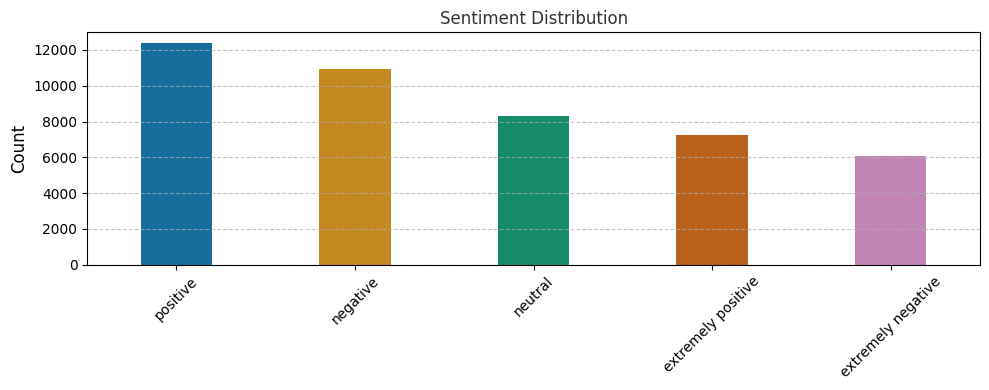

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Count
sentiment_df = df["sentiment"].value_counts().reset_index(name="size")

_, ax = plt.subplots(figsize=(10, 4))
plt.style.use("ggplot")

sns.barplot(
    sentiment_df, x="sentiment", y="size", hue="sentiment", palette="colorblind", gap=0.5, ax=ax
)

# Axis Labels and Title
ax.set_title("Sentiment Distribution", fontsize=12, alpha=0.8)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("")
plt.xticks(rotation=45)

ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

#### **Data Processing & Cleaning**

In [13]:
import re
import nltk
import string
import contractions
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
# Download NLTK resources
nltk.download("popular", quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

In [15]:
# Define Stopwords
covid_19_stopwords = ["covid", "coronavirus", "pandemic", "virus", "lockdown", "quarantine", "vaccine"]
custom_stopwords = covid_19_stopwords + stopwords.words()

# Lemmatizer
lemma = WordNetLemmatizer()

def preprocess_text(df: pd.DataFrame) -> pd.DataFrame:

    data = df.copy()

    # Clean the text
    data['text'] = data['tweet'].str.lower()
    data['text'] = data['text'].apply(contractions.fix)
    data['text'] = data['text'].str.replace(r'https:\W.+','', regex=True)
    data['text'] = data['text'].str.replace(r'@\w+|&\w+','', regex=True)
    data['text'] = data['text'].str.replace(r'[%s]'%re.escape(string.punctuation),' ', regex=True)
    data['text'] = data['text'].str.replace(r'\d+\w+','', regex=True)

    # Tokenize and preprocess
    data['text'] = data['text'].apply(word_tokenize)
    data['text'] = data['text'].apply(lambda tokens: [lemma.lemmatize(word) for word in tokens])
    data['text'] = data['text'].str.join(" ")

    # Handle encoding and decoding issues
    data['text'] = data['text'].apply(lambda s: s.encode('ascii', 'ignore'))
    data['text'] = data['text'].apply(lambda s: s.decode('utf-8'))

    # Remove stopwords (and potentially filter short words)
    data['text'] = data['text'].apply(lambda text: [word for word in text.split() if word not in custom_stopwords and len(word) > 2])
    data['text'] = data['text'].str.join(" ")
    return data[['tweet', 'text', 'sentiment']]

# Processed DataSet
dataframe = preprocess_text(df)
dataframe = (
    dataframe[~(dataframe.text.str.split()
    .apply(lambda s: len(s)) < 2)]
    .dropna().drop_duplicates()
    .reset_index(drop=True)
)

# Define Labels for readability
sentiment_labels = ['neg(-)', 'ext-pos(+)', 'neu(0)', 'ext-neg(-)', 'pos(+)']
map_labels = {k: c for c, k in zip(sentiment_labels, dataframe["sentiment"].unique())}
dataframe["sentiment"] = df["sentiment"].map(map_labels)

dataframe.head()

,tweet,text,sentiment
0,"coronavirus latest:drivers in #nj, around country still seeing gas prices drop amid covid- - mar 21 @ 10:28 am et https://t.co/zxlzvhbyvw",latest driver country gas price drop amid,neg(-)
1,itâs a difficult time for everyone at the moment but please do not stockpile and panic buy.. if you just buy what you need as normal there will be plenty of food and essential supplies for everyo...,difficult time moment stockpile panic buy buy normal plenty food essential supply thinkofothers especially elderly dontbeselfish,ext-pos(+)
2,"or buy gift certificates for others who may be in self-quarantine. a little online shopping will pass the time and keep local businesses alive. plus, more books! #coronavirus #books",buy gift certificate online shopping time local business alive book book,ext-pos(+)
3,"""la rental prices fall for the first time in a decade.""\r\r\n#coronavirus #realestate #investment \r\r\n\r\r\nhttps://t.co/1hniyhoooa",rental price fall time decade realestate investment,neu(0)
4,covid-19 coronavirus: rotorua shoppers wear beekeeping suits to supermarket ????? https://t.co/qfpj5kzn1p,rotorua shopper wear beekeeping suit supermarket,neu(0)


#### **Save Processed Data**

In [43]:
%%bash
# Create processed folder only if it does not exist in the folder tree.
FILE_DIR="processed"

if [[ ! -d "$FILE_DIR" ]]; then
    echo "Create '$FILE_DIR' folder ..."
    mkdir -p processed
else
    echo "Folder '$FILE_DIR' already exists."
fi

Folder 'processed' already exists.


In [44]:
!rm -rf processed/corona_tweets_covid19.csv

In [45]:
# Naming file output
FILE_NAME = "corona_tweets_covid19.csv"
FILE_OUTPUT = os.path.join("processed", FILE_NAME)

# Log existing files into file_log.txt
!find . -maxdepth 2 -type f > file_log.txt

# Load existing files into a pyton list
with open("file_log.txt", "r") as f:
    list_files = [file.split("/")[-1].rstrip() for file in f.readlines()]
    print(list_files)

['notebook_v001.ipynb', 'description', 'packed-refs', 'HEAD', 'config', 'index', 'COMMIT_EDITMSG', 'README.md', 'file_log.txt', 'notebook_v002.ipynb', '.gitignore']


In [46]:
if FILE_NAME not in list_files:
    print("Saving processed dataset ...")
    dataframe.to_csv(FILE_OUTPUT, index=False)
else:
    print(f"File '{FILE_OUTPUT}' already created.")

Saving processed dataset ...
